# Atomic Systems

There are several more atomic systems implemented, such as `BCC_BINARY`, `BCC_BINARY_VACANCY`, `BCC_VACANCY`, `BCC_SIA`, `HCP`, as well as generic `FromData`.
The source code related to systems is in the `./lammps_implicit_der/systems/` folder. Each system is a child class of `LammpsImplicitDer`.

Specifying SNAP file paths is mandatory for any system.


In [10]:
# Standard libraries
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Package imports
from lammps_implicit_der import SNAP, LammpsImplicitDer
from lammps_implicit_der.systems import BCC, BCC_BINARY, BCC_BINARY_VACANCY, BCC_VACANCY, \
                                        BCC_SIA, FromData, HCP, \
                                        BccVacancyConcentration
from lammps_implicit_der.tools import plot_tools

# No parallel MPI runs in the notebook, but keep comm for consistency
comm = None

# For parallel runs, use the following:
# from lammps_implicit_der.tools import mpi_print, initialize_mpi
# comm, rank = initialize_mpi()

## Pure BCC lattice

* `alat`: lattice parameter in Angstrom
* `ncell_x`: number of BCC unit cells in the x-direction. If `ncell_y` and `ncell_z` are not specified, they will be equal to `ncell_x`

In [11]:
bcc_pure = BCC(alat=3.18, ncell_x=2, minimize=True, snapcoeff_filename='W.snapcoeff',
               verbose=False, comm=comm)
print(f'Energy of BCC pure (eV): {bcc_pure.energy:.6f}')

Energy of BCC pure (eV): -151.595842


## BCC Vacancy

BCC with one vacancy

* `del_coord`: Coordinates of the atom to be deleted. If None, `del_id` must be specified. Shape: (3,)
* `del_id`: ID of the atom to be deleted. If None, `del_coord` must be specified.

In [12]:
bcc_vacancy = BCC_VACANCY(alat=3.18, ncell_x=2, minimize=True, del_coord=[0.0, 0.0, 0.0],
                          snapcoeff_filename = 'W_REF.snapcoeff', verbose=False, comm=comm)

print(f'Energy of BCC Vacancy (eV): {bcc_vacancy.energy:.6f}')
print(f'ID of atom that was delterd: {bcc_vacancy.del_id}')

Energy of BCC Vacancy (eV): -80.299289
ID of atom that was delterd: 1


## BCC lattice with vacancies, with a specified vacancy concentration.

* `vac_conc`: concentration of vacanies, in the [0, 1] range.

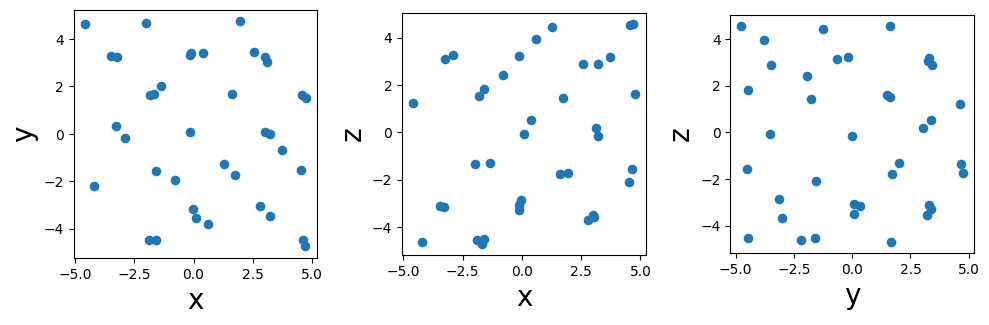

In [13]:
bcc_vac_conc = BccVacancyConcentration(alat=3.18, ncell_x=3, minimize=True, vac_conc=0.3,
                                       verbose=False, snapcoeff_filename='W_REF.snapcoeff', comm=comm)

# Plot the coordinates of the atoms in XY, XZ, and YZ planes
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
plot_tools.plot_coords(axes, bcc_vac_conc.X_coord.reshape(-1, 3), s=35)
plt.tight_layout()
plt.show()

## Hexagonal Close-Packed (HCP) lattice

$$
\begin{bmatrix}
    a & 0 & 0 \\
    0 & b & 0 \\
    0 & 0 & c
\end{bmatrix}
$$

## Fixed $a/c$

In this case, $b = a \sqrt{3}$, $c = a \sqrt{8/3}$

In [14]:
alat_hcp = 2.84752278
hcp_fixed_a_c = HCP(alat=alat_hcp, ncell_x=1, minimize=True, fix_box_relax=False,
                    snapcoeff_filename='W_REF.snapcoeff', verbose=False, comm=comm)

print(f'HCP cell: \n{hcp_fixed_a_c.cell}')
print(f'Parameter a (A): {hcp_fixed_a_c.cell[0, 0]:.3f}')
print(f'Parameter b (A): {hcp_fixed_a_c.cell[1, 1]:.3f}, a * sqrt(3): {alat_hcp * np.sqrt(3):.3f}')
print(f'Parameter c (A): {hcp_fixed_a_c.cell[2, 2]:.3f}, a * sqrt(8/3): {alat_hcp * np.sqrt(8/3):.3f}')

HCP cell: 
[[2.84752278 0.         0.        ]
 [0.         4.93205413 0.        ]
 [0.         0.         4.64998523]]
Parameter a (A): 2.848
Parameter b (A): 4.932, a * sqrt(3): 4.932
Parameter c (A): 4.650, a * sqrt(8/3): 4.650


## HCP, relaxed in the $c$-direction

With anisotropic box relaxation (`fix_box_relax=True` and `box_relax_iso=False`)

In [15]:
alat_hcp = 2.84752278
hcp_box_relax = HCP(alat=alat_hcp, ncell_x=1,
                    minimize=True, fix_box_relax=True, minimize_maxiter=1000, box_relax_iso=False,
                    snapcoeff_filename='W.snapcoeff', verbose=True, comm=comm)

print(f'HCP cell: \n{hcp_box_relax.cell}')
print(f'Parameter a (A): {hcp_box_relax.cell[0, 0]:.3f}')
print(f'Parameter b (A): {hcp_box_relax.cell[1, 1]:.3f}, a * sqrt(3): {alat_hcp * np.sqrt(3):.3f}')
print(f'Parameter c (A): {hcp_box_relax.cell[2, 2]:.3f}, a * sqrt(8/3): {alat_hcp * np.sqrt(8/3):.3f}')



--------------------------------------------------------------------------------
Running LAMMPS with the following arguments:
-screen none -log none

Setting SNAP potential

                  SNAP coefficients for: W
                          quadraticflag: 0
 Number of parameters (excluding beta0): 55
                                Element:  W  |  R =  0.5000 w =  1.0000

Minimizing energy with the following parameters:
ftol: 1e-08, maxiter: 1000, maxeval: 1000, algo: cg, fix_box_relax: True 

Minimization finished in 230 steps
Initial fmax: 5.301e-15, final fmax: 8.694e-14
Initial fnorm: 7.698e-15, final fnorm: 1.879e-13
Number of atoms: 4, largest force value: 8.694e-14, force norm: 1.879e-13
HCP cell: 
[[2.85232327 0.         0.        ]
 [0.         4.94036882 0.        ]
 [0.         0.         4.7557049 ]]
Parameter a (A): 2.852
Parameter b (A): 4.940, a * sqrt(3): 4.932
Parameter c (A): 4.756, a * sqrt(8/3): 4.650


## BCC binary

* `specie_B_concentration`: Concentration of the B species in the binary lattice, [0, 1]. Specie A concentration is 1 - specie_B_concentration.

Warning: currently, the $\mathbf{\Theta}$ parameters are hardcoded to Mo.

Atomic species list: [1 1 1 2 2 2 2 2 2 1 1 2 1 1 1 1]


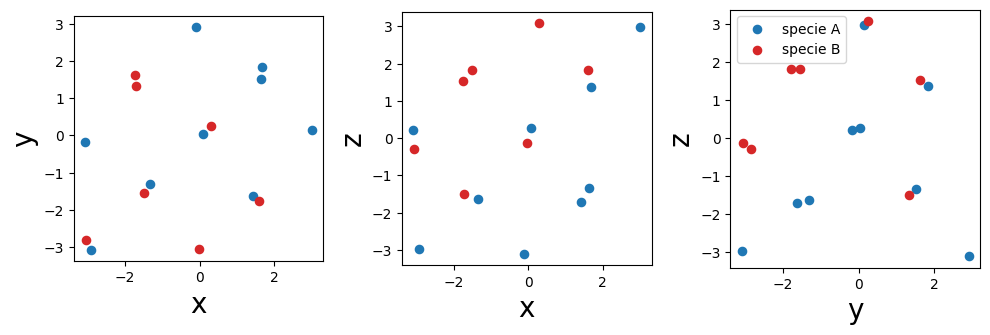

Number of SNAP descriptors: 30
Ni SNAP parameters: [ 0.00278888 -0.00957282  0.08327857 -0.05374547  0.28790446]...
Mo SNAP parameters: [0.00217993 0.02117406 0.05027489 0.01271017 0.32806724]...


In [16]:
bcc_binary = BCC_BINARY(alat=3.13, ncell_x=2, minimize=True,
                        snapcoeff_filename = 'NiMo.snapcoeff', verbose=False)

print(f'Atomic species list: {bcc_binary.species}')

# Plot the coordinates of the atoms in XY, XZ, and YZ planes
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
species_A_coord = bcc_binary.X_coord.reshape(-1, 3)[bcc_binary.species == 1]
species_B_coord = bcc_binary.X_coord.reshape(-1, 3)[bcc_binary.species == 2]
plot_tools.plot_coords(axes, species_A_coord, s=35, color='tab:blue', label='specie A')
plot_tools.plot_coords(axes, species_B_coord, s=35, color='tab:red', label='specie B')
plt.tight_layout()
plt.show()

print(f'Number of SNAP descriptors: {bcc_binary.Ndesc}')
print(f'Ni SNAP parameters: {bcc_binary.pot.Theta_dict["Ni"]["Theta"][:5]}...')
print(f'Mo SNAP parameters: {bcc_binary.pot.Theta_dict["Mo"]["Theta"][:5]}...')

## BCC  with self-interstitial atom (SIA) defect

* `SIA_pos`: Coordinates of the self-interstitial atom in lattice units. If None, the default position is 0.25 + origin_pos.

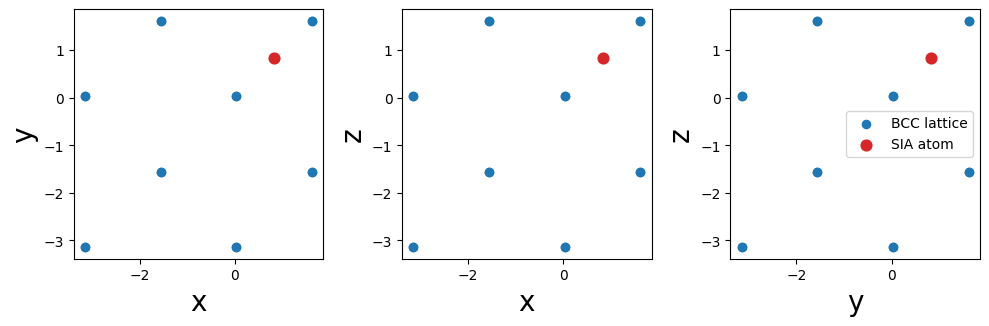

In [17]:
alat = 3.18
bcc_SIA = BCC_SIA(alat=alat, ncell_x=2, minimize=False,
                  snapcoeff_filename = 'W_REF.snapcoeff', verbose=False)

# Plot the coordinates of the atoms in XY, XZ, and YZ planes
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
plot_tools.plot_coords(axes, bcc_SIA.X_coord.reshape(-1, 3), s=35, label='BCC lattice')
SIA_pos_2D = bcc_SIA.SIA_pos_lat_units.reshape(1, 3) * alat
plot_tools.plot_coords(axes, SIA_pos_2D, s=60, color='tab:red', label='SIA atom')
plt.tight_layout()
plt.show()

## `FromData` class: Initialize a system from a LAMMPS-data file

* `datafile`: LAMMPS data file name

In [18]:
# For demonstration purposes, create a LAMMPS data file
system = BCC(alat=3.175, ncell_x=2, ncell_y=1, ncell_z=1, minimize=True, logname=None,
             snapcoeff_filename='W_REF.snapcoeff', fix_box_relax=False, verbose=False)
system.write_data('test.data')

# Create a FromData class instance
new_system = FromData(datafile='test.data', snapcoeff_filename='W_REF.snapcoeff', verbose=False)

# To check, print the energy
print(f'Energy of new_system (eV): {new_system.energy:.6f}')
print(f'Number of atoms in new_system: {new_system.Natom}')

Energy of new_system (eV): -22.258871
Number of atoms in new_system: 4


### `FromData` object with an input script

* `input_script`: alternatively, specify a text input script to inialize an object

In [19]:
input_script = """
        atom_modify map array sort 0 0.0
        units metal
        boundary p p p
        lattice bcc 3.175 origin 0.01 0.01 0.01
        region C block 0 2 0 1 0 1 units lattice
        create_box 1 C
        create_atoms 1 region C
        mass * 184.
"""


new_system2 = FromData(input_script=input_script, snapcoeff_filename='W_REF.snapcoeff', verbose=False)

print(f'Energy of new_system2 (eV): {new_system2.energy:.6f}')
print(f'Number of atoms in new_system2: {new_system2.Natom}')

Energy of new_system2 (eV): -22.258871
Number of atoms in new_system2: 4


## Create a new system

The fastest way to create a new atomic system is use the `FromData` class with a LAMMPS data file.

 More 'sustainable' way to do so, is to create a new child class from `LammpsImplicitDer`, as shown below.

 For example, let us create a BCC lattice with two vacanies. We will create a BCC lattice with LAMMPS commands and manually delete the atoms with ID's 1 and 2.

In [20]:
class BCC_two_vac(LammpsImplicitDer):
    def __init__(self,
                 ncell_x=2,
                 alat=3.1855,
                 element_mass=183.84,
                 *args, **kwargs):

        # Inherit the parent initialization first
        super().__init__(*args, **kwargs)

        # Set some basic attributes
        self.alat = alat
        self.ncell_x = ncell_x
        self.element_mass = element_mass

        # Create a SNAP potential instance
        self.pot = SNAP.from_files(self.snapcoeff_filename,
                                   data_path=self.data_path,
                                   snapparam_filename=self.snapparam_filename, comm=self.comm)

        # Set the BCC_two_vac Theta parameters to the first element in the SNAP potential
        self.element = self.pot.elem_list[0]
        self.Theta = self.pot.Theta_dict[self.element]['Theta']

        # Initialize the lattice
        self.lmp_commands_string(f"""
        boundary p p p
        lattice bcc {self.alat} origin 0.01 0.01 0.01

        # create a block of atoms
        region C block 0 {self.ncell_x} 0 {self.ncell_x} 0 {self.ncell_x} units lattice
        create_box 1 C

        # add atoms
        create_atoms 1 region C
        """)

        # Delete two atoms with ID's 1 and 2
        self.lmp_commands_string(f"""
        # delete one atom
        # Create a group called 'del' with the atom to be deleted
        group del id 1 2
        delete_atoms group del
        """)

        # Set up the mass (not important for molecular statics)
        self.lmp_commands_string(f'mass * {self.element_mass}')

        # Run the initilization (setup SNAP in LAMMPS, gather from LAMMPS the coordinates, descriptors, etc.)
        self.run_init()

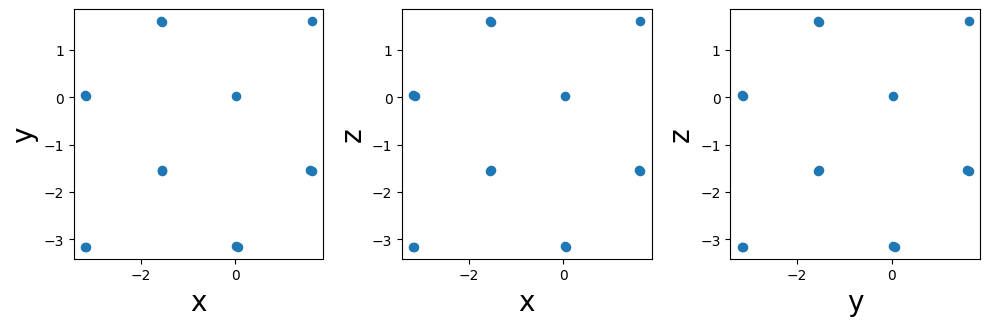

Number of atomis in bcc_two_vac: 14


In [21]:
# Create a BCC_two_vac instance and minimize with fixed lattice parameter (fix_box_relax=False)
bcc_two_vac = BCC_two_vac(alat=3.18, snapcoeff_filename='W_REF.snapcoeff', minimize=True, fix_box_relax=False,
                          verbose=False, comm=comm)

# Plot the coordinates of the atoms in XY, XZ, and YZ planes
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
plot_tools.plot_coords(axes, bcc_two_vac.X_coord.reshape(-1, 3), s=35)
plt.tight_layout()
plt.show()

print(f'Number of atomis in bcc_two_vac: {bcc_two_vac.Natom}')